## Supplementary Figure 18

MOA predictions - Alternate views

Panels:

- a) Examples of poor predictions
- b) Concatenated model prediction performance
- c) Performance in subsampled Cell Painting
- d) Performance across dose

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggrepel))
suppressPackageStartupMessages(library(patchwork))

source("viz_themes.R")
source("plotting_functions.R")
source("data_functions.R")

In [2]:
output_figure_base <- file.path("figures", "supplementary", "figureS18_moaprediction_alt")
extensions <- c(".png", ".pdf")

In [3]:
# Set internal constants
dl_moa_targets <- c(
    "hsp inhibitor" = "HSP inhibitor",
    "plk inhibitor" = "PLK inhibitor",
    "glucocorticoid receptor antagonist" = "Glucocorticoid receptor antagonist"
)

metric_dir <- file.path("..", "2.MOA-prediction", "metrics")
performance_dir <- file.path("../2.MOA-prediction/4.model_viz/performance_results")

updated_assay_colors <- c(assay_colors, "Cell Painting (subsample)" = "pink", "Cell Painting & L1000" = "black")

In [4]:
# Load average precision scores for all models and targets
ap_file <- file.path(metric_dir, "average_precision_full_results.tsv.gz")

ap_cols <- readr::cols(
  average_precision = readr::col_double(),
  target = readr::col_character(),
  assay = readr::col_character(),
  model = readr::col_character(),
  shuffle = readr::col_logical(),
  data_split = readr::col_character(),
  target_category = readr::col_character()
)

ap_df <- readr::read_tsv(ap_file, col_types = ap_cols)

print(dim(ap_df))
head(ap_df, 2)

[1] 48547     9


average_precision,target,assay,model,shuffle,data_split,subsample_status,target_category,n_pos_count
<dbl>,<chr>,<chr>,<chr>,<lgl>,<chr>,<lgl>,<chr>,<dbl>
0.0009466525,11-beta hydroxysteroid dehydrogenase inhibitor,cp,mlknn,TRUE,train,TRUE,moa,17
0.0009980768,11-beta-hsd1 inhibitor,cp,mlknn,TRUE,train,TRUE,moa,18


In [5]:
# Load data for visualization
targets_list <- list(
    "panel_a" = c("hsp inhibitor", "plk inhibitor", "glucocorticoid receptor antagonist")
)

results_dir <- file.path("..", "2.MOA-prediction", "metrics", "pr_curves")
results_prefix <- "precision_recall_curve__"
results_suffix <- ".tsv.gz"
plot_category <- "main"

pr_df <- list()
for (panel in names(targets_list)) {
    pr_df[[panel]] <- list()
    focus_targets <- targets_list[[panel]]
    for (target in focus_targets) {
        
        # Load precision recall curves
        pr_temp_df <- process_pr_deeplearning_data(
            target = target,
            results_dir = results_dir,
            results_prefix = results_prefix,
            results_suffix = results_suffix,
            plot_category = plot_category
        )
        
        # Reorder model factor
        pr_temp_df$model <- factor(pr_temp_df$model, levels = names(model_names))
        
        # Recode and reorder compound names
        pr_temp_df$target <- factor(pr_temp_df$target, levels = focus_targets)
        pr_temp_df$target <- dplyr::recode_factor(pr_temp_df$target, !!!dl_moa_targets)
        
        # Store in list
        pr_df[[panel]][[target]] <- pr_temp_df
    }
    pr_df[[panel]] <- dplyr::bind_rows(pr_df[[panel]])
}

## Panel A

Examples of poor predictions

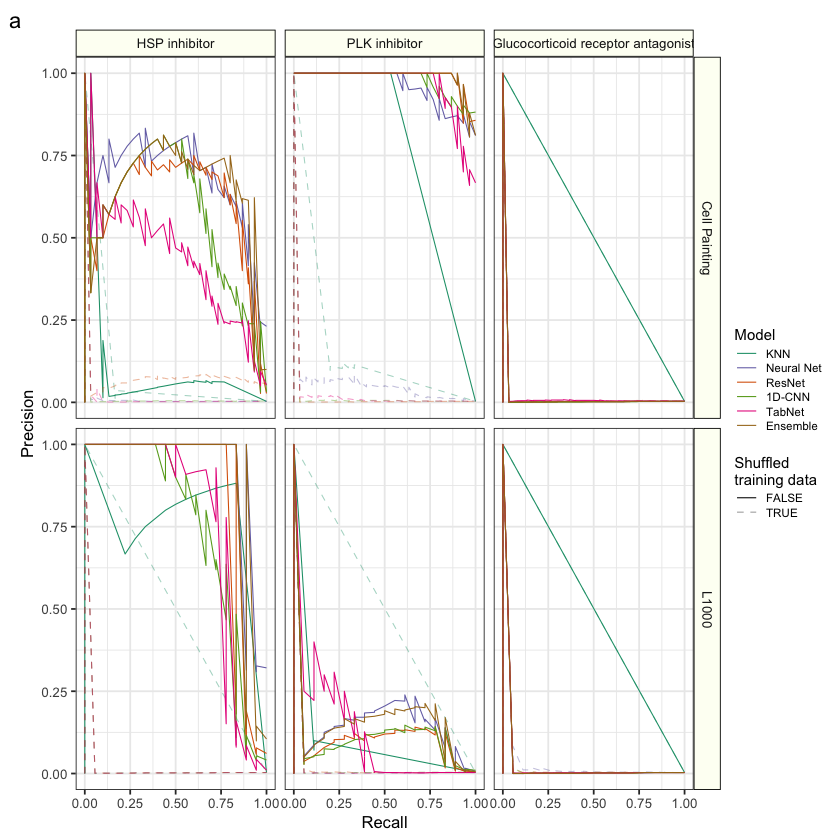

In [6]:
panel_a_gg <- (
    ggplot(pr_df[["panel_a"]], aes(x = recall_round, y = precision_round))
    + geom_line(aes(color = model, linetype = data_shuffle, alpha = data_shuffle), lwd = 0.3)
    + facet_grid("assay~target")
    + figure_theme
    + xlab("Recall")
    + ylab("Precision")
    + scale_color_manual(name = "Model", labels = model_names, values = model_colors)
    + scale_linetype_manual(name = "Shuffled\ntraining data", labels = shuffled_labels, values = shuffled_linetypes)
    + scale_alpha_manual(name = "Shuffled\ntraining data", labels = shuffled_labels, values = shuffled_alphas)
    + guides(
        color = guide_legend(order = 1),
        linetype = guide_legend(order = 2),
        alpha = guide_legend(order = 2)
    )
    + theme(
        legend.spacing.y = unit(0.1, "cm"),
        legend.box.spacing = unit(0.1, "cm"),
        legend.key.size = unit(0.6, "lines"),
        legend.key.width = unit(1, "lines")
    )
    + labs(tag = "a")
)

panel_a_gg

## Panel B - Concatenated profiling tech

In [7]:
# Load metrics results
metrics_file <- file.path(performance_dir, "all_performance_metrics.csv")

metrics_cols <- readr::cols(
    id_name = readr::col_character(),
    metrics = readr::col_character(),
    values = readr::col_double(),
    profile_tech = readr::col_character(),
    model = readr::col_character(),
    shuffle = readr::col_logical()
)

all_metrics_df <- readr::read_csv(metrics_file, col_types = metrics_cols) %>%
    dplyr::mutate(updated_metric = values / 100)

# Process data
all_metrics_df$profile_tech <- dplyr::recode(
    all_metrics_df$profile_tech,
    `Cell painting` = "Cell Painting",
    `Cell painting subsample` = "Cell Painting (subsample)"
)
all_metrics_df$metrics <- dplyr::recode(
    all_metrics_df$metrics, `Precision-Recall_AUC` = "Precision-recall", `ROC_AUC` = "ROC"
)
all_metrics_df$metrics <- factor(all_metrics_df$metrics, levels = c("ROC", "Precision-recall"))
all_metrics_df$model <- factor(
    all_metrics_df$model,
    levels = c("Ml-KNN", "Simple NN", "ResNet", "1D-CNN", "TabNet", "Models Ensemble")
)
all_metrics_df$model <- dplyr::recode(
    all_metrics_df$model, `Models Ensemble` = "Ensemble", "Ml-KNN" = "KNN", "Simple NN" = "Neural Net" 
)

all_metrics_df$profile_tech <- dplyr::recode(
    all_metrics_df$profile_tech,
    `Cell painting & L1000` = "Cell Painting & L1000"
)

all_metrics_df$profile_tech <- factor(
    all_metrics_df$profile_tech,
    levels = c("Cell Painting", "Cell Painting (subsample)", "L1000", "Cell Painting & L1000")
)

head(all_metrics_df)

id_name,metrics,values,profile_tech,model,shuffle,updated_metric
<chr>,<fct>,<dbl>,<fct>,<fct>,<lgl>,<dbl>
CP_mlknn,Precision-recall,1.013924,Cell Painting,KNN,FALSE,0.01013924
CP_resnet,Precision-recall,3.776332,Cell Painting,ResNet,FALSE,0.03776332
CP_cnn,Precision-recall,4.524989,Cell Painting,1D-CNN,FALSE,0.04524989
CP_tabnet,Precision-recall,3.130228,Cell Painting,TabNet,FALSE,0.03130228
CP_simplenn,Precision-recall,4.201865,Cell Painting,Neural Net,FALSE,0.04201865
CP_blend,Precision-recall,4.144751,Cell Painting,Ensemble,FALSE,0.04144751


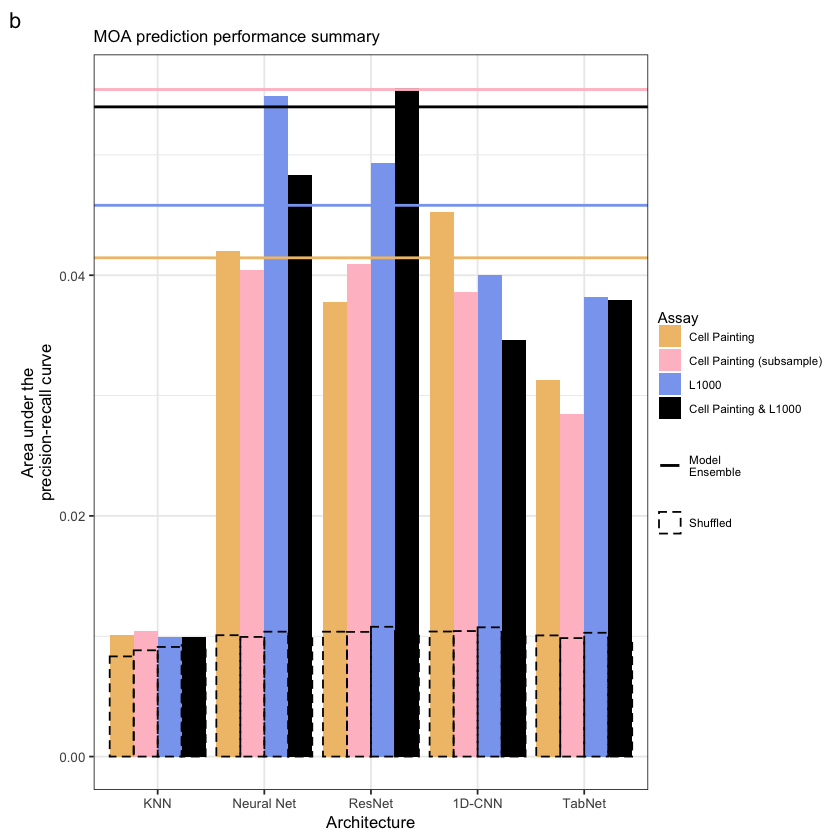

In [8]:
panel_b_df <- all_metrics_df %>%
    dplyr::filter(metrics == 'Precision-recall')

ensemble_df <- panel_b_df %>%
    dplyr::filter(model == "Ensemble")

panel_b_df <- panel_b_df %>%
    dplyr::filter(model != "Ensemble")

panel_b_gg <- (
    ggplot(data = NULL, aes(x = model, y = updated_metric))
    + geom_bar(
        data = panel_b_df %>% dplyr::filter(!shuffle),
        stat = "identity",
        aes(fill = profile_tech),
        position = "dodge"
    )
    + geom_bar(
        data = panel_b_df %>% dplyr::filter(shuffle),
        stat = "identity",
        aes(color = profile_tech),
        alpha = 0,
        position = "dodge",
        linetype = "dashed"
    )
    + ggtitle("MOA prediction performance summary")
    + figure_theme
    + theme(
        legend.spacing.y = unit(0.01, "cm"),
        legend.box.spacing = unit(0.01, "cm"),
        legend.key.size = unit(0, "lines"),
        legend.key.width = unit(1, "lines"),
        legend.key.height = unit(1, "lines"),
        plot.title = element_text(size = 10)
    )
    + scale_fill_manual("Assay", values = updated_assay_colors)
    + scale_color_manual(breaks = "Cell Painting", name = "", values = c("black", "black", "black", "black"), labels = c("Shuffled"))
    + scale_linetype_manual(name = "", values = "solid", labels = "Model\nEnsemble")
    + geom_hline(data = ensemble_df, aes(yintercept = updated_metric, linetype = "Ensemble"), color = paste(updated_assay_colors), lwd = 0.8)    
    + xlab("Architecture")
    + ylab("Area under the\nprecision-recall curve")
    + guides(
        fill = guide_legend(order = 1),
        color = guide_legend(order = 3),
        linetype = guide_legend(order = 2)
    )
    + labs(tag = "b")
)

panel_b_gg

## Panel C - Performance metrics by dose

In [9]:
# Load and process dose results
metrics_dose_file <- file.path(performance_dir, "all_performance_metrics_by_dose.csv")

metrics_dose_cols <- readr::cols(
    id_name = readr::col_character(),
    metrics = readr::col_character(),
    values = readr::col_double(),
    class = readr::col_character(),
    model = readr::col_character(),
    profile_tech = readr::col_character()
)

all_dose_metrics_df <- readr::read_csv(metrics_dose_file, col_types = metrics_dose_cols) %>%
    dplyr::mutate(performance = values) %>%
    dplyr::mutate(updated_metric = values / 100)

# Process data
all_dose_metrics_df$profile_tech <- dplyr::recode(
    all_dose_metrics_df$profile_tech,
    cp = "Cell Painting",
    cpsubsample = "Cell Painting (subsample)"
)

all_dose_metrics_df$metrics <- dplyr::recode(all_dose_metrics_df$metrics, pr_auc_score = "Precision-recall")
all_dose_metrics_df$model <- dplyr::recode(
    all_dose_metrics_df$model,
    mlknn = "Ml-KNN", simplenn = "Simple NN", cnn = "1D-CNN", resnet = "ResNet", tabnet = "TabNet"
)

all_dose_metrics_df$model <- factor(
    all_dose_metrics_df$model,
    levels = c("Ml-KNN", "Simple NN", "ResNet", "1D-CNN", "TabNet")
)
all_dose_metrics_df$class <- dplyr::recode(
    all_dose_metrics_df$class,
    dose_1 = dose_order[1],
    dose_2 = dose_order[2],
    dose_3 = dose_order[3],
    dose_4 = dose_order[4],
    dose_5 = dose_order[5],
    dose_6 = dose_order[6]
)
all_dose_metrics_df$class <- factor(all_dose_metrics_df$class, levels = dose_order)

all_dose_metrics_df$profile_tech <- dplyr::recode(
    all_dose_metrics_df$profile_tech,
    CP_L1000 = "Cell Painting & L1000"
)
all_dose_metrics_df$profile_tech <- factor(
    all_dose_metrics_df$profile_tech,
    levels = c("Cell Painting", "Cell Painting (subsample)", "L1000", "Cell Painting & L1000")
)

head(all_dose_metrics_df)

id_name,metrics,values,class,model,profile_tech,performance,updated_metric
<chr>,<chr>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<dbl>
moa_dose_cp_mlknn_1,Precision-recall,0.008886675,0.04 uM,Ml-KNN,Cell Painting,0.008886675,8.886675e-05
moa_dose_cp_resnet_1,Precision-recall,0.023070155,0.04 uM,ResNet,Cell Painting,0.023070155,2.307015e-04
moa_dose_cp_cnn_1,Precision-recall,0.030706467,0.04 uM,1D-CNN,Cell Painting,0.030706467,3.070647e-04
moa_dose_cp_tabnet_1,Precision-recall,0.018743846,0.04 uM,TabNet,Cell Painting,0.018743846,1.874385e-04
moa_dose_cp_simplenn_1,Precision-recall,0.027240617,0.04 uM,Simple NN,Cell Painting,0.027240617,2.724062e-04
moa_dose_cp_mlknn_2,Precision-recall,0.009794520,0.12 uM,Ml-KNN,Cell Painting,0.009794520,9.794520e-05


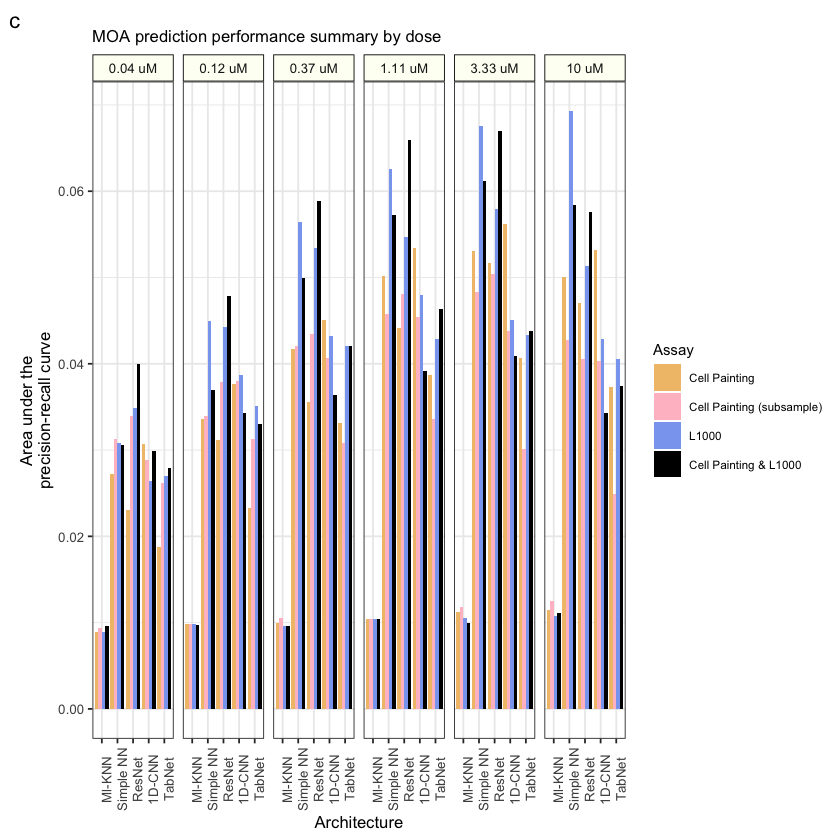

In [10]:
panel_c_df <- all_dose_metrics_df %>%
    dplyr::filter(metrics == 'Precision-recall')

panel_c_gg <- (
    ggplot(panel_c_df, aes(x = model, y = performance))
    + geom_bar(aes(fill = profile_tech), position = "dodge", stat = "identity")
    + facet_grid("~class")
    + figure_theme
    + theme(
        axis.text.x = element_text(angle = 90),
        plot.title = element_text(size = 10)
    )
    + xlab("Model")
    + ylab("Area under the precision-recall curve")
    + ggtitle("MOA prediction performance summary by dose")
    + scale_fill_manual("Assay", values = updated_assay_colors)
    + scale_color_manual(
        breaks = "Cell Painting",
        name = "",
        values = c("black", "black", "black", "black"),
        labels = c("Shuffled")
    )
    + scale_linetype_manual(name = "", values = "solid", labels = "Model\nEnsemble")
    + xlab("Architecture")
    + ylab("Area under the\nprecision-recall curve")
    + guides(
        fill = guide_legend(order = 1),
        color = guide_legend(order = 3),
        linetype = guide_legend(order = 2)
    )
    + labs(tag = "c")
)

panel_c_gg

## Compile figure

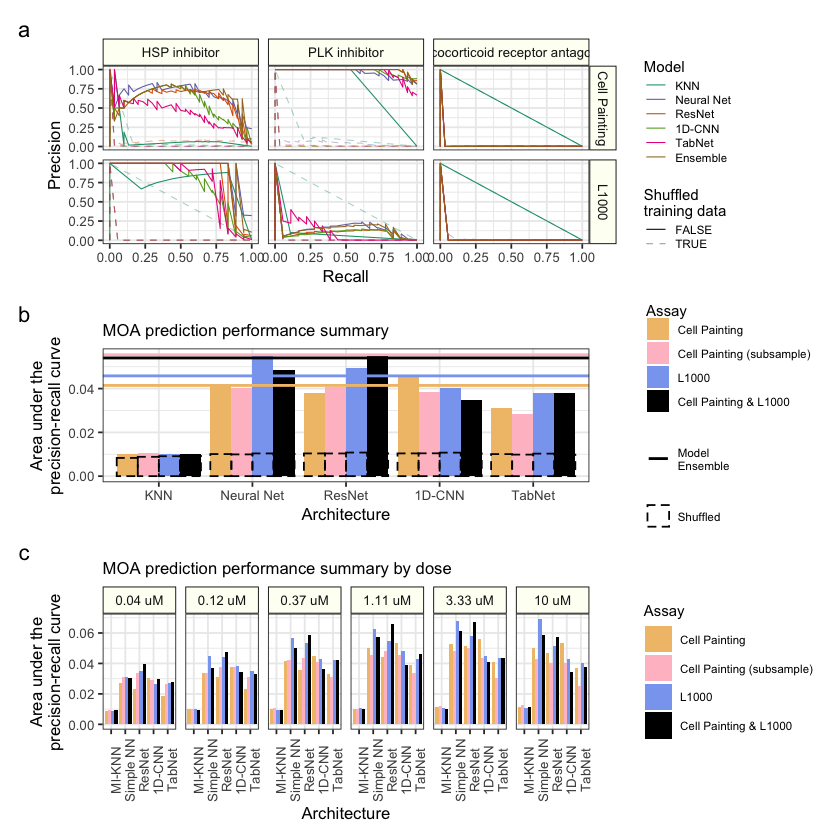

In [11]:
sup_fig_gg <- (
    panel_a_gg /
    panel_b_gg /
    panel_c_gg
) + plot_layout(heights = c(1, 0.75, 0.65))

for (extension in extensions) {
    output_file <- paste0(output_figure_base, extension)
    ggplot2::ggsave(output_file, sup_fig_gg, height = 9.5, width = 8.5, dpi = 500)
}

sup_fig_gg